In [1]:
import xarray as xr
import datetime
import os
from glob import glob
import matplotlib.pyplot as plt
from cmocean import cm
import numpy as np
import cartopy.crs as ccrs
import matplotlib.colors as colors
from matplotlib import axes

os.environ['CARTOPY_USER_BACKGROUNDS'] = '/home/shkifmjr/cartopy_images/'

import warnings
warnings.simplefilter('ignore')

img = plt.imread('/home/shkifmjr/cartopy_images/BlueMarble_TOPO_010_FEB.png')

In [2]:
OR10_03_nest = '/scratch/usr/shkifmmp/postproc_ORION10/velocities/'

OR10_03_k10 = '/scratch/usr/shkifmmp/postproc_ORION10/velocities/vel_eke_k10/'

In [3]:
#mask for nest
mask_path = '/scratch/usr/shklvn09/NUDATA/ORION/10-data/meshmask/1_mesh_mask.nc'
mask =xr.open_dataset(mask_path, chunks={"z":46, "y":100, "x":100})#.tmask.isel(z=0).squeeze()
mask = mask.rename({'z':'deptht'}) #renaming dimension z to deptht

In [4]:
tmask = mask.tmask.isel(deptht=0).squeeze()

In [5]:
e1t = mask.e1t.squeeze()
e2t = mask.e2t.squeeze()

In [ ]:
! ncdump -h /scratch/usr/shkifmmp/postproc_ORION10/velocities/*1976*EKE*
# ! ncdump -h /scratch/usr/shkifmmp/postproc_ORION10/velocities/vel_eke_k10/*EKE*1976*

## Comparing different methodologies for eke (cdo and cdfeke) - for the nest

### Differences between methods:
### eke_03_k10 (CDO):

#### UU mean -> step 1
\\$cdo mul \\${PATH}/\\${CONFIG}-\\${CASE}_5d_\\${YEAR}\\${YEAR}1231_vozocrtx_k10.nc \\${PATH}/\\${CONFIG}-\\${CASE}_5d_\\${YEAR}0101_\\${YEAR}1231_vozocrtx_k10.nc uu.nc
 
\\$cdo mul \\${PATH}/\\${CONFIG}-\\${CASE}_5d_\\${YEAR}0101_\\${YEAR}1231_vomecrty_k10.nc \\${PATH}/\\${CONFIG}-\\${CASE}_5d_\\${YEAR}0101_\\${YEAR}1231_vomecrty_k10.nc vv.nc

\\$cdo timselavg,73 uu.nc uu_mean.nc

\\$cdo timselavg,73 vv.nc vv_mean.nc

#### Umean * Umean -> step 2
\\$cdo timselavg,73 \\${PATH}/\\${CONFIG}-\\${CASE}_5d_\\${YEAR}0101_\\${YEAR}1231_vozocrtx_k10.nc u_mean.nc

\\$cdo timselavg,73 \\${PATH}/\\${CONFIG}-\\${CASE}_5d_\\${YEAR}0101_\\${YEAR}1231_vomecrty_k10.nc v_mean.nc

\\$cdo mul u_mean.nc u_mean.nc mean_uu.nc
\\$cdo mul v_mean.nc v_mean.nc mean_vv.nc

#### U' * U' -> step3
\\$cdo sub uu_mean.nc mean_uu.nc uu_prime.nc

\\$cdo sub vv_mean.nc mean_vv.nc vv_prime.nc

#### EKE -> step 4
\\$cdo add uu_prime.nc vv_prime.nc eke_tmp.nc

\\$cdo mulc,0.5 eke_tmp.nc EKE_\\${YEAR}.nc

### eke_03_cdo (CDO, lavinia's way) -- starts after step 2 from above

#### TKE
\\$cdo add uu_mean_\\${YEAR}.nc vv_mean_\\${YEAR}.nc tke_tmp_\\${YEAR}.nc

\\$cdo mulc,0.5 tke_tmp_\\${YEAR}.nc TKE_\\${YEAR}.nc

#### MKE
\\$cdo add mean_uu_\\${YEAR}.nc mean_vv_\\${YEAR}.nc mke_tmp_\\${YEAR}.nc

\\$cdo mulc,0.5 mke_tmp_\\${YEAR}.nc MKE_\\${YEAR}.nc

#### EKE
\\$cdo sub TKE_\\${YEAR}_tmp.nc MKE_\\${YEAR}.nc EKE_cdo_\\${YEAR}.nc

### eke_03_76 (CDO + CDFEKE) -- after step 2 (before calculating mean_uu.nc)

\# renaming variables

\\$ncrename -v vozocrtx,vozocrtx_sqd uu_mean_\\${YEAR}.nc

\\$ncrename -v vomecrty,vomecrty_sqd vv_mean_\\${YEAR}.nc

### EKE
\\$cdfeke -u u_mean_\\${YEAR}.nc -u2 uu_mean_\\${YEAR}.nc -v v_mean_\\${YEAR}.nc -v2 vv_mean_\\${YEAR}.nc -t \\${PATH}/\\${CONFIG}-\\${CASE}_5d_\\${YEAR}0101_\\${YEAR}1231_grid_T.nc -o \\${CONFIG}-\\${CASE}_1y_\\${YEAR}0101_\\${YEAR}1231_EKE.nc

### eke_03_calc (CDFEKE - calculating separately MKE and TKE and then EKE)
\# must add parameter '-mke -tke' in the above cdfeke command, it will return also votke and vomke variables in the ncfile, then:

\\$ncap2 -s "EKE_calc=(votke-vomke)" \\${CONFIG}-\\${CASE}_1y_\\${YEAR}0101_\\${YEAR}1231_EKE.nc \\${CONFIG}-\\${CASE}_1y_\\${YEAR}0101_\\${YEAR}1231_EKE.nc



In [6]:
eke_03_k10 = xr.open_dataset(OR10_03_k10 + 'EKE_1976.nc').vozocrtx.squeeze().where(tmask) #Calculated with CDO (my way)
eke_03_k10 = eke_03_k10.rename({'depthu':'deptht'})
eke_03_76 = xr.open_dataset(OR10_03_nest + '1_ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP03_1y_19760101_19761231_EKE.nc',
                           chunks={"deptht":46, "y":100, "x":100}).voeke.isel(deptht=9).squeeze().where(tmask) # Calculated with CDO and cdfeke


In [7]:
eke_03_cdo = xr.open_dataset(OR10_03_nest + 'EKE_cdo_1976.nc').vozocrtx.isel(depthu=9).squeeze().where(tmask) #lavinia's way
eke_03_cdo = eke_03_cdo.rename({'depthu':'deptht'})

In [ ]:
eke_03_76

In [ ]:
# EKE calculated with cdfeke (tke-mke)
eke_03_calc = xr.open_dataset(OR10_03_nest + '1_ORION10.L46.LIM2vp.CFCSF6.MOPS.JRA.XIOS2.5-EXP03_1y_19760101_19761231_EKE_tmp.nc',
                           chunks={"deptht":46, "y":100, "x":100}).EKE_calc.isel(deptht=9).squeeze().where(tmask) #Calculated eith cdfeke (tke-mke)

### Dealing with the descontinuity in k10

In [11]:
eke_03_k10.coords["x"] = range(len(eke_03_k10.x))
eke_03_k10.coords["y"] = range(len(eke_03_k10.y))

eke_03_cdo.coords["x"] = range(len(eke_03_cdo.x))
eke_03_cdo.coords["y"] = range(len(eke_03_cdo.y))

In [12]:
after_discont = ~(eke_03_k10.coords["nav_lon"].diff("x", label="upper") > 0).cumprod("x").astype(bool)
after_discont_cdo = ~(eke_03_cdo.coords["nav_lon"].diff("x", label="upper") > 0).cumprod("x").astype(bool)

In [13]:
eke_03_k10.coords["nav_lon"] = (
    eke_03_k10.coords["nav_lon"]
    + 360 * after_discont
)

eke_03_cdo.coords["nav_lon"] = (
    eke_03_cdo.coords["nav_lon"]
    + 360 * after_discont_cdo
)

In [14]:
eke_03_76 = eke_03_76.assign_coords(nav_lat= eke_03_k10.coords['nav_lat'])

In [15]:
eke_03_k10 = eke_03_k10.isel(x=slice(1, -1), y=slice(None, -1))
eke_03_cdo = eke_03_cdo.isel(x=slice(1, -1), y=slice(None, -1))
eke_03_76 = eke_03_76.isel(x=slice(1, -1), y=slice(None, -1))
#eke_03_calc = eke_03_calc.isel(x=slice(1, -1), y=slice(None, -1))

### Plotting

In [ ]:
#Difference between k10 (calculated with CDO entirely) and 76 (cdfeke tool)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14,8))#, subplot_kw={'projection': ccrs.NearsidePerspective(central_latitude=-90)})
LOGMIN=0.00001 #Lognorm does not work with vmin=0

map1 = eke_03_k10.plot.pcolormesh(x='nav_lon', y='nav_lat', ax=axs[0],
                          norm=colors.LogNorm(vmin=max(eke_03_k10.min(), LOGMIN), vmax=0.29456654),
                            add_colorbar=False,
                          cmap=cm.thermal)

map2 = (eke_03_k10 - eke_03_76).plot.pcolormesh(x='nav_lon', y='nav_lat', ax=axs[1], #transform=ccrs.PlateCarree(),
                                         vmax = 0.015,
                                         vmin= -0.015,
                                         norm=colors.SymLogNorm(linthresh=0.001, vmin=-0.015, vmax=0.015),
                                         #norm=colors.TwoSlopeNorm(vcenter=0),
                                         add_colorbar=False,
                                         cmap=cm.balance)

axs[0].set_title('1_ORION10 EKE at 100m (1976) calculated with cdo', fontsize=14)
axs[1].set_title('Difference between cdo and cdfeke method', fontsize=14)

for maps, ax in zip([map1, map2], axs):
    ax.axes.xaxis.set_visible(False)
    ax.set_ylabel('Latitude', fontsize=14)
    c = plt.colorbar(maps, pad=0.02, shrink=0.7, ax=ax)
    if maps == map1:
        c.ax.set_title('$(m^{2}\,s^{-2})$', loc='left', fontsize=14)
    c.ax.tick_params(labelsize=14)
    axes.Axes.tick_params(ax, axis='both' ,labelsize=14)

plt.tight_layout()

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/figures/'
#plt.savefig(savepath + 'eke_diff_log.png', format='png', facecolor="w")
#plt.savefig(savepath + 'eke_diff_linear.png', format='png', facecolor="w")

In [ ]:
# DIFF CDFEKE AND CDFEKE (TKE-MKE)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14,8))#, subplot_kw={'projection': ccrs.NearsidePerspective(central_latitude=-90)})
LOGMIN=0.00001 #Lognorm does not work with vmin=0

map1 = eke_03_76.plot.pcolormesh(x='nav_lon', y='nav_lat', ax=axs[0],
                          norm=colors.LogNorm(vmin=max(eke_03_76.min(), LOGMIN), vmax=0.29456654),
                          add_colorbar=False,
                          cmap=cm.thermal)

map2 = (eke_03_76 - eke_03_calc).plot.pcolormesh(x='nav_lon', y='nav_lat', ax=axs[1], #transform=ccrs.PlateCarree(),
                                         vmax = 1e-7,
                                         vmin= -1e-7,
                                         norm=colors.SymLogNorm(linthresh=1e-8, vmin=-1e-7, vmax=1e-7),
                                          add_colorbar=False,
                                         #norm=colors.TwoSlopeNorm(vcenter=0),
                                         cmap=cm.balance)

axs[0].set_title('1_ORION10 EKE at 100m (1976) calculated with cdfeke', fontsize=14)
axs[1].set_title('Difference between cdfeke and cdfeke (tke-mke) method', fontsize=14)

for maps, ax in zip([map1, map2], axs):
    ax.axes.xaxis.set_visible(False)
    ax.set_ylabel('Latitude', fontsize=14)
    c = plt.colorbar(maps, pad=0.02, shrink=0.7, ax=ax)
    if maps == map1:
        c.ax.set_title('$(m^{2}\,s^{-2})$', loc='left', fontsize=14)
    c.ax.tick_params(labelsize=14)
    axes.Axes.tick_params(ax, axis='both' ,labelsize=14)

plt.tight_layout()

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/figures/'
#plt.savefig(savepath + 'eke_diff_cdfeke_tke.png', format='png', facecolor="w")

In [ ]:
## DIFF between cdo and cdfeke (tke-mke)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14,8))#, subplot_kw={'projection': ccrs.NearsidePerspective(central_latitude=-90)})
LOGMIN=0.00001 #Lognorm does not work with vmin=0

map1 = eke_03_k10.plot.pcolormesh(x='nav_lon', y='nav_lat', ax=axs[0],
                          norm=colors.LogNorm(vmin=max(eke_03_k10.min(), LOGMIN), vmax=0.29456654),
                           add_colorbar=False,
                          cmap=cm.thermal)

map2 = (eke_03_k10 - eke_03_calc).plot.pcolormesh(x='nav_lon', y='nav_lat', ax=axs[1], #transform=ccrs.PlateCarree(),
                                         vmax = 0.015,
                                         vmin= -0.015,
                                         norm=colors.SymLogNorm(linthresh=0.001, vmin=-0.015, vmax=0.015),
                                         #norm=colors.TwoSlopeNorm(vcenter=0),
                                           add_colorbar=False,
                                         cmap=cm.balance)

axs[0].set_title('1_ORION10 EKE at 100m (1976) calculated with cdo', fontsize=14)
axs[1].set_title('Difference between cdo and cdfeke (tke-mke) method', fontsize=14)

for maps, ax in zip([map1, map2], axs):
    ax.axes.xaxis.set_visible(False)
    ax.set_ylabel('Latitude', fontsize=14)
    c = plt.colorbar(maps, pad=0.02, shrink=0.7, ax=ax)
    if maps == map1:
        c.ax.set_title('$(m^{2}\,s^{-2})$', loc='left', fontsize=14)
    c.ax.tick_params(labelsize=14)
    axes.Axes.tick_params(ax, axis='both' ,labelsize=14)

plt.tight_layout()

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/figures/'
#plt.savefig(savepath + 'eke_diff_cdo_tke.png', format='png', facecolor="w")

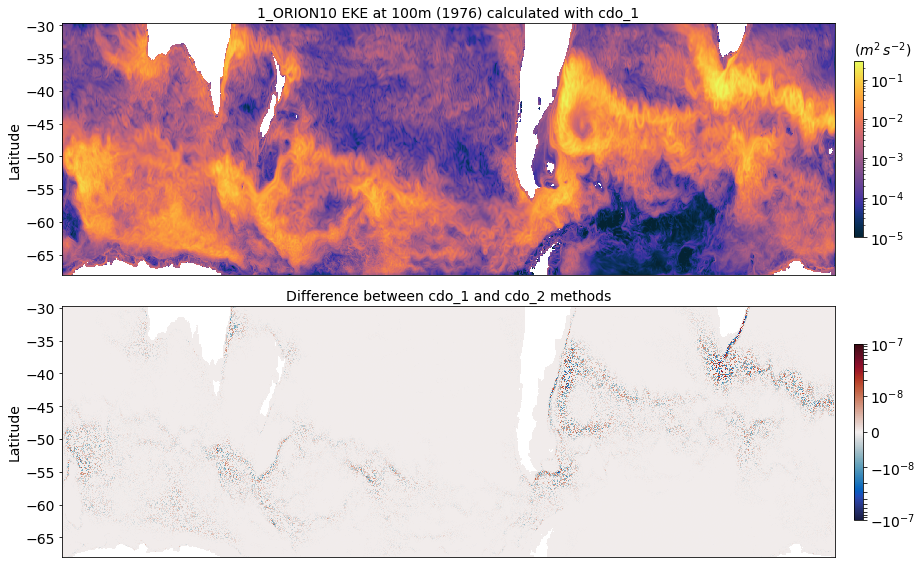

In [25]:
#Difference between cdo (calculated with CDO entirely) and cdo (lavinia's way)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14,8))#, subplot_kw={'projection': ccrs.NearsidePerspective(central_latitude=-90)})
LOGMIN=0.00001 #Lognorm does not work with vmin=0

map1 = eke_03_k10.plot.pcolormesh(x='nav_lon', y='nav_lat', ax=axs[0],
                          norm=colors.LogNorm(vmin=max(eke_03_k10.min(), LOGMIN), vmax=0.29456654),
                            add_colorbar=False,
                          cmap=cm.thermal)

map2 = (eke_03_k10 - eke_03_cdo).plot.pcolormesh(x='nav_lon', y='nav_lat', ax=axs[1], #transform=ccrs.PlateCarree(),
                                         vmax = 1e-7,
                                         vmin= -1e-7,
                                         norm=colors.SymLogNorm(linthresh=1e-8, vmin=-1e-7, vmax=1e-7),
                                         #norm=colors.TwoSlopeNorm(vcenter=0),
                                         add_colorbar=False,
                                         cmap=cm.balance)

axs[0].set_title('1_ORION10 EKE at 100m (1976) calculated with cdo_1', fontsize=14)
axs[1].set_title('Difference between cdo_1 and cdo_2 methods', fontsize=14)

for maps, ax in zip([map1, map2], axs):
    ax.axes.xaxis.set_visible(False)
    ax.set_ylabel('Latitude', fontsize=14)
    c = plt.colorbar(maps, pad=0.02, shrink=0.7, ax=ax)
    if maps == map1:
        c.ax.set_title('$(m^{2}\,s^{-2})$', loc='left', fontsize=14)
    c.ax.tick_params(labelsize=14)
    axes.Axes.tick_params(ax, axis='both' ,labelsize=14)

plt.tight_layout()

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/figures/'
plt.savefig(savepath + 'eke_diff_cdo_log.png', format='png', facecolor="w")
#plt.savefig(savepath + 'eke_diff_linear.png', format='png', facecolor="w")

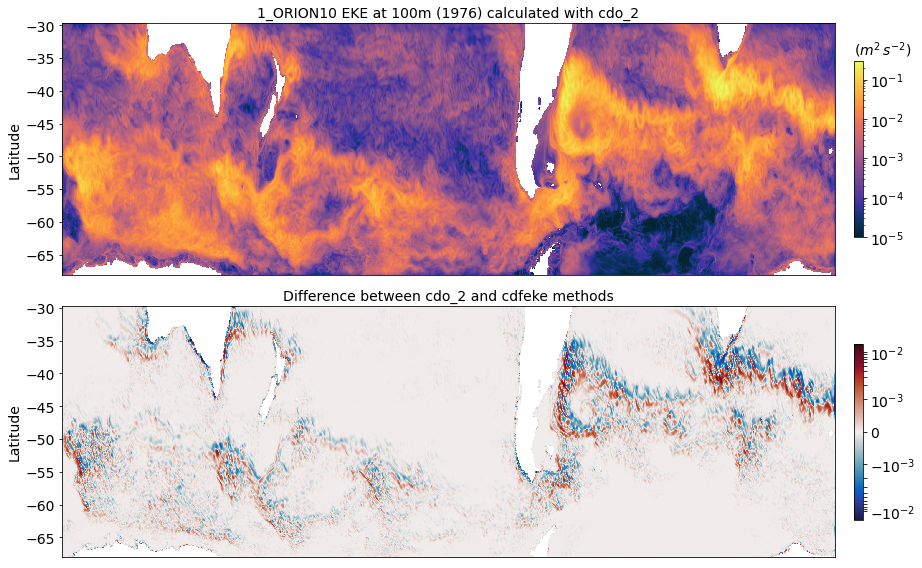

In [26]:
#Difference between cdo (lavinia's way) and 76 (cdfeke tool)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14,8))#, subplot_kw={'projection': ccrs.NearsidePerspective(central_latitude=-90)})
LOGMIN=0.00001 #Lognorm does not work with vmin=0

map1 = eke_03_k10.plot.pcolormesh(x='nav_lon', y='nav_lat', ax=axs[0],
                          norm=colors.LogNorm(vmin=max(eke_03_k10.min(), LOGMIN), vmax=0.29456654),
                            add_colorbar=False,
                          cmap=cm.thermal)

map2 = (eke_03_cdo - eke_03_76).plot.pcolormesh(x='nav_lon', y='nav_lat', ax=axs[1], #transform=ccrs.PlateCarree(),
                                         vmax = 0.015,
                                         vmin= -0.015,
                                         norm=colors.SymLogNorm(linthresh=0.001, vmin=-0.015, vmax=0.015),
                                         #norm=colors.TwoSlopeNorm(vcenter=0),
                                         add_colorbar=False,
                                         cmap=cm.balance)

axs[0].set_title('1_ORION10 EKE at 100m (1976) calculated with cdo_2', fontsize=14)
axs[1].set_title('Difference between cdo_2 and cdfeke methods', fontsize=14)

for maps, ax in zip([map1, map2], axs):
    ax.axes.xaxis.set_visible(False)
    ax.set_ylabel('Latitude', fontsize=14)
    c = plt.colorbar(maps, pad=0.02, shrink=0.7, ax=ax)
    if maps == map1:
        c.ax.set_title('$(m^{2}\,s^{-2})$', loc='left', fontsize=14)
    c.ax.tick_params(labelsize=14)
    axes.Axes.tick_params(ax, axis='both' ,labelsize=14)

plt.tight_layout()

savepath = '/home/shkifmmp/_WORK/notebooks/shared-notebooks/figures/'
plt.savefig(savepath + 'eke_diff_cdo2_cdfeke_log.png', format='png', facecolor="w")
#plt.savefig(savepath + 'eke_diff_linear.png', format='png', facecolor="w")